In [2]:
!pip install pandas numpy matplotlib seaborn scipy statsmodels scikit-learn

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.0 MB 4.1 MB/s eta 0:00:03
   ------ --------------------------------- 1.8/11.0 MB 4.8 MB/s eta 0:00:02
   -------- ------------------------------- 2.4/11.0 MB 4.6 MB/s eta 0:00:02
   ------------- -------------------------- 3.7/11.0 MB 4.7 MB/s eta 0:00:02
   ----------------- ---------------------- 4.7/11.0 MB 4.7 MB/s eta 0:00:02
   ------------------- -------------------- 5.2/11.0 MB 4.5 MB/s eta 0:00:02
   ----------------------- ---------------- 6.6/11.0 MB 4.6 MB/s eta 0:00:01
   -------------------------- ------------- 7.3/11.0 MB 4.8 MB/s eta 0:00:01
   -------------------------- ------------- 7.3/11.0 MB 4.8 MB/s eta 0:00:01
   ---------------------------- ----------- 7.9/11.0 MB 3.9 MB/s eta 0:00:01
   ----------------------------- ---------- 8.1/11.0 MB 3.6 MB/s eta 0:00:01
   --

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from typing import Optional, Dict, Any
import warnings

In [4]:
warnings.filterwarnings('ignore')

In [5]:
np.random.seed(42)

In [7]:
plt.style.use('default')


In [8]:

sns.set_palette("husl")

In [11]:
def get_descriptive_stats(data: pd.DataFrame) -> pd.DataFrame:
    """
    Python equivalent of R's summary() and stat.desc()
    """
    print("=== DESCRIPTIVE STATISTICS ===")
    
    # Basic summary (equivalent to R's summary())
    print("Basic Summary:")
    print(data.describe(include='all'))
    
    # Detailed statistics for numeric columns (equivalent to stat.desc())
    numeric_cols = data.select_dtypes(include=[np.number])
    detailed_stats = numeric_cols.describe().T
    
    # Add additional statistics similar to R's stat.desc()
    detailed_stats['variance'] = numeric_cols.var()
    detailed_stats['skewness'] = numeric_cols.skew()
    detailed_stats['kurtosis'] = numeric_cols.kurtosis()
    
    print("\nDetailed Statistics:")
    print(detailed_stats)
    
    return detailed_stats


In [12]:
def analyze_correlations(data: pd.DataFrame) -> pd.DataFrame:
    """
    Python equivalent of R's cor() and corrplot()
    """
    print("\n=== CORRELATION ANALYSIS ===")
    
    # Calculate correlation matrix
    numeric_data = data.select_dtypes(include=[np.number])
    cor_matrix = numeric_data.corr()
    
    # Create correlation plot (equivalent to corrplot())
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(cor_matrix, dtype=bool))  # Upper triangle mask
    sns.heatmap(cor_matrix, mask=mask, annot=True, cmap='RdBu_r', 
                center=0, square=True, fmt='.3f')
    plt.title("Correlation Matrix")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return cor_matrix


In [13]:
def compare_groups(data: pd.DataFrame, group_var: str, numeric_var: str) -> Dict:
    """
    Python equivalent of R's ggplot boxplot + statistical tests
    """
    print(f"\n=== GROUP COMPARISON: {numeric_var} by {group_var} ===")
    
    # Box plot visualization (equivalent to ggplot + geom_boxplot)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=group_var, y=numeric_var, data=data, palette="Set2")
    plt.title(f"{numeric_var} by {group_var}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Statistical tests
    unique_groups = data[group_var].unique()
    groups_data = [data[data[group_var] == group][numeric_var].dropna() 
                   for group in unique_groups]
    
    if len(unique_groups) > 2:
        # Kruskal-Wallis test for multiple groups
        stat, p_value = stats.kruskal(*groups_data)
        test_name = "Kruskal-Wallis"
        print(f"{test_name} Test Result:")
        print(f"Statistic: {stat:.6f}, P-value: {p_value:.6f}")
    else:
        # Mann-Whitney U test for two groups (equivalent to wilcox.test)
        stat, p_value = stats.mannwhitneyu(groups_data[0], groups_data[1], 
                                           alternative='two-sided')
        test_name = "Mann-Whitney U"
        print(f"{test_name} Test Result:")
        print(f"Statistic: {stat:.6f}, P-value: {p_value:.6f}")
    
    return {'test': test_name, 'statistic': stat, 'p_value': p_value}


In [14]:
def check_assumptions(data: pd.DataFrame, variable: str) -> Optional[Dict]:
    """
    Python equivalent of R's qqnorm, qqline, and shapiro.test
    """
    print(f"\n=== ASSUMPTION CHECKING for {variable} ===")
    
    var_data = data[variable].dropna()
    
    # Create Q-Q plot and histogram
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Q-Q plot (equivalent to qqnorm + qqline)
    stats.probplot(var_data, dist="norm", plot=axes[0])
    axes[0].set_title(f"Q-Q Plot: {variable}")
    axes[0].grid(True)
    
    # Histogram with normal distribution overlay
    axes[1].hist(var_data, bins=30, density=True, alpha=0.7, 
                 color='skyblue', edgecolor='black')
    xmin, xmax = axes[1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, var_data.mean(), var_data.std())
    axes[1].plot(x, p, 'r-', linewidth=2, label='Normal Distribution')
    axes[1].set_title(f"Histogram: {variable}")
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Shapiro-Wilk test
    if len(var_data) <= 5000:
        shapiro_stat, shapiro_p = stats.shapiro(var_data)
        print("Shapiro-Wilk Test:")
        print(f"Statistic: {shapiro_stat:.6f}, P-value: {shapiro_p:.6f}")
        return {'statistic': shapiro_stat, 'p_value': shapiro_p}
    else:
        print("Sample size too large for Shapiro-Wilk test")
        return None


In [15]:
def perform_anova(data: pd.DataFrame, dependent_var: str, independent_var: str) -> Dict:
    """
    Python equivalent of R's aov() and TukeyHSD()
    """
    print(f"\n=== ANOVA: {dependent_var} ~ {independent_var} ===")
    
    # Perform ANOVA using statsmodels
    formula = f'{dependent_var} ~ C({independent_var})'
    model = smf.ols(formula, data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    print("ANOVA Table:")
    print(anova_table)
    
    # Get p-value for significance test
    p_value = anova_table['PR(>F)'].iloc[0]
    
    results = {'anova': anova_table, 'model': model}
    
    # Post-hoc test if significant (equivalent to TukeyHSD)
    if not pd.isna(p_value) and p_value < 0.05:
        print("\nPerforming Tukey HSD post-hoc test:")
        tukey = pairwise_tukeyhsd(data[dependent_var], data[independent_var])
        print(tukey.summary())
        results['tukey'] = tukey
    
    return results


In [16]:
def fit_mixed_model(data: pd.DataFrame, dependent_var: str, 
                   fixed_effect: str, random_effect: str) -> object:
    """
    Python equivalent of R's lmer()
    """
    print(f"\n=== LINEAR MIXED MODEL: {dependent_var} ===")
    
    try:
        # Create formula for mixed effects model
        formula = f'{dependent_var} ~ {fixed_effect}'
        
        # Fit mixed effects model
        model = smf.mixedlm(formula, data, groups=data[random_effect])
        result = model.fit()
        
        print("Mixed Effects Model Summary:")
        print(result.summary())
        
        return result
    except Exception as e:
        print(f"Mixed model failed: {str(e)}")
        print("Falling back to regular OLS regression...")
        
        # Fallback to regular regression
        formula = f'{dependent_var} ~ C({fixed_effect})'
        model = smf.ols(formula, data=data).fit()
        print(model.summary())
        
        return model


In [17]:
def build_decision_tree(data: pd.DataFrame, target_var: str) -> DecisionTreeClassifier:
    """
    Python equivalent of R's rpart() and rpart.plot()
    """
    print(f"\n=== DECISION TREE for {target_var} ===")
    
    # Prepare features and target
    X = data.drop(columns=[target_var])
    y = data[target_var]
    
    # Encode categorical variables
    X_encoded = pd.get_dummies(X, drop_first=True)
    
    # Handle categorical target variable
    if y.dtype == 'object' or pd.api.types.is_categorical_dtype(y):
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        class_names = le.classes_
    else:
        y_encoded = y
        class_names = None
    
    # Build decision tree
    tree_model = DecisionTreeClassifier(random_state=42, max_depth=5)
    tree_model.fit(X_encoded, y_encoded)
    
    # Plot tree (equivalent to rpart.plot)
    plt.figure(figsize=(20, 10))
    plot_tree(tree_model, 
              filled=True, 
              feature_names=X_encoded.columns,
              class_names=[str(name) for name in class_names] if class_names is not None else None,
              rounded=True,
              fontsize=10)
    plt.title(f"Decision Tree: {target_var}")
    plt.tight_layout()
    plt.show()
    
    # Print feature importance
    importance = pd.DataFrame({
        'feature': X_encoded.columns,
        'importance': tree_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Feature Importance:")
    print(importance.head())
    
    return tree_model


In [18]:
def create_heatmap(data: pd.DataFrame, scale_data: bool = True) -> pd.DataFrame:
    """
    Python equivalent of R's pheatmap()
    """
    print("\n=== HEATMAP ANALYSIS ===")
    
    # Select numeric columns
    numeric_data = data.select_dtypes(include=[np.number])
    
    # Scale data if requested
    if scale_data:
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        scaled_array = scaler.fit_transform(numeric_data)
        scaled_data = pd.DataFrame(scaled_array, 
                                   columns=numeric_data.columns, 
                                   index=numeric_data.index)
        title = "Scaled Heatmap"
    else:
        scaled_data = numeric_data
        title = "Heatmap"
    
    # Create clustered heatmap (equivalent to pheatmap)
    plt.figure(figsize=(12, 10))
    sns.clustermap(scaled_data, 
                   cmap='RdBu_r', 
                   center=0,
                   method='average',
                   metric='euclidean',
                   figsize=(12, 10))
    plt.suptitle(title)
    plt.show()
    
    return scaled_data


In [21]:
def run_complete_analysis(data: pd.DataFrame, target_var: str, 
                         numeric_var: str, group_var: str, 
                         id_var: Optional[str] = None) -> Dict[str, Any]:
    """
    Python equivalent of R's run_complete_r_analysis()
    """
    print("####################################################")
    print("# COMPREHENSIVE PYTHON STATISTICAL ANALYSIS PIPELINE #")
    print("####################################################")
    
    results = {}
    
    # 1. Descriptive Statistics
    results['descriptive'] = get_descriptive_stats(data)
    
    # 2. Correlation Analysis
    results['correlations'] = analyze_correlations(data)
    
    # 3. Group Comparison
    results['group_comparison'] = compare_groups(data, group_var, numeric_var)
    
    # 4. Assumption Checking
    results['assumptions'] = check_assumptions(data, numeric_var)
    
    # 5. ANOVA
    results['anova'] = perform_anova(data, numeric_var, group_var)
    
    # 6. Mixed Model (if ID variable provided)
    if id_var is not None and id_var in data.columns:
        results['mixed_model'] = fit_mixed_model(data, numeric_var, group_var, id_var)
    else:
        results['mixed_model'] = None
    
    # 7. Decision Tree
    results['decision_tree'] = build_decision_tree(data, target_var)
    
    # 8. Heatmap
    results['heatmap'] = create_heatmap(data)
    
    print("\n####################################################")
    print("# PYTHON ANALYSIS COMPLETE - ALL FUNCTIONS EXECUTED #")
    print("####################################################")
    
    return results


####################################################
# COMPREHENSIVE PYTHON STATISTICAL ANALYSIS PIPELINE #
####################################################
=== DESCRIPTIVE STATISTICS ===
Basic Summary:
                id group       score category      value1      value2  outcome
count   200.000000   200  200.000000      200  200.000000  200.000000      200
unique         NaN     3         NaN        3         NaN         NaN        2
top            NaN     C         NaN      Low         NaN         NaN  Success
freq           NaN    73         NaN       82         NaN         NaN      123
mean    100.500000   NaN  100.326075      NaN   50.787154   30.465233      NaN
std      57.879185   NaN   14.767743      NaN   10.276666    5.432595      NaN
min       1.000000   NaN   65.228976      NaN   23.912120   16.076822      NaN
25%      50.750000   NaN   89.939765      NaN   43.583020   26.800432      NaN
50%     100.500000   NaN   99.587403      NaN   51.701979   30.237244      NaN
75%

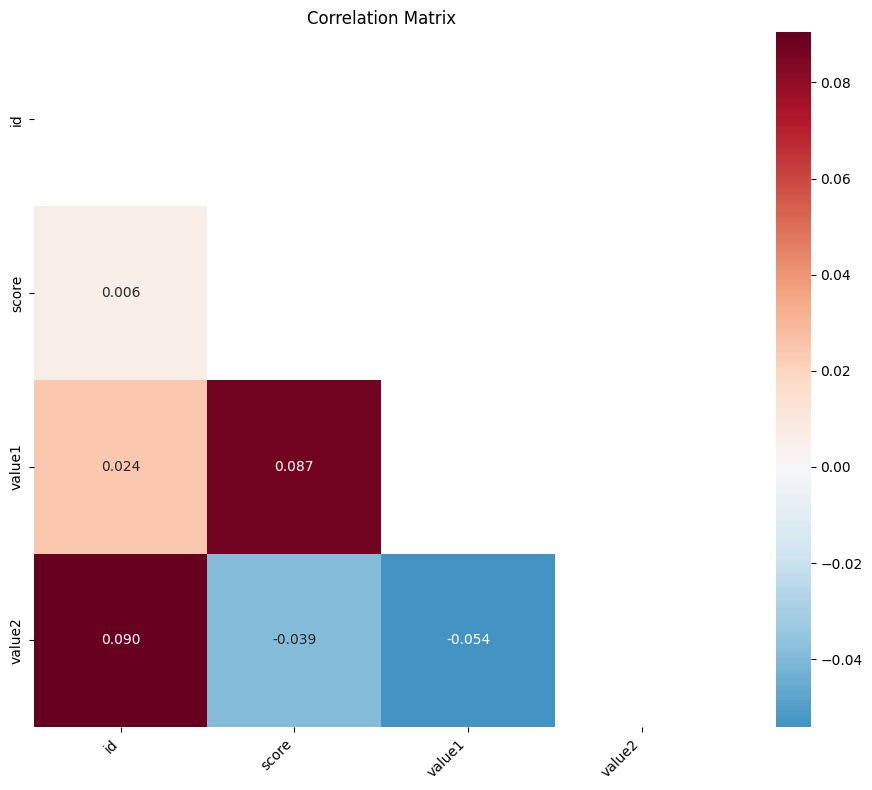


=== GROUP COMPARISON: score by group ===


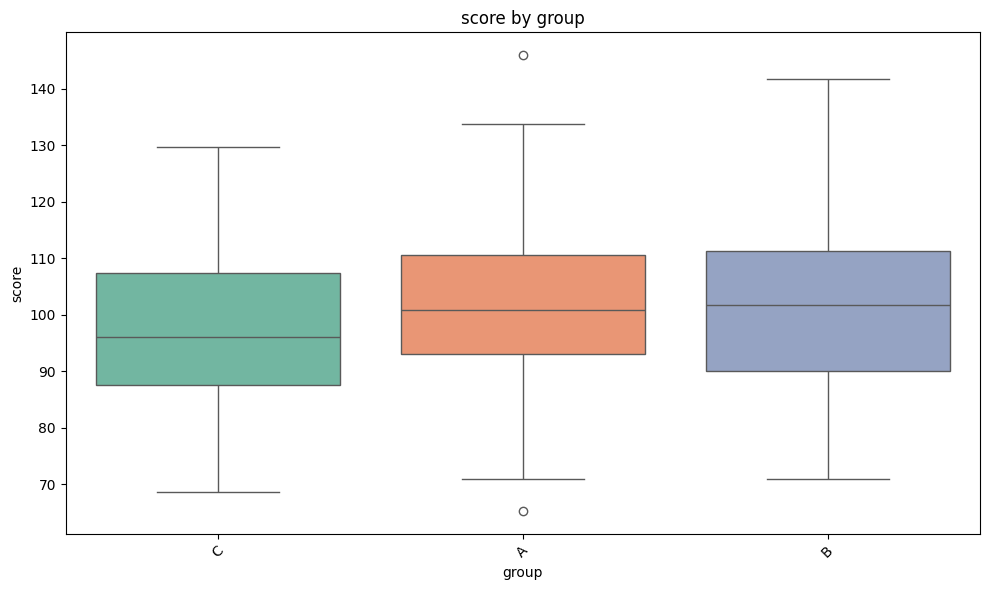

Kruskal-Wallis Test Result:
Statistic: 5.063080, P-value: 0.079536

=== ASSUMPTION CHECKING for score ===


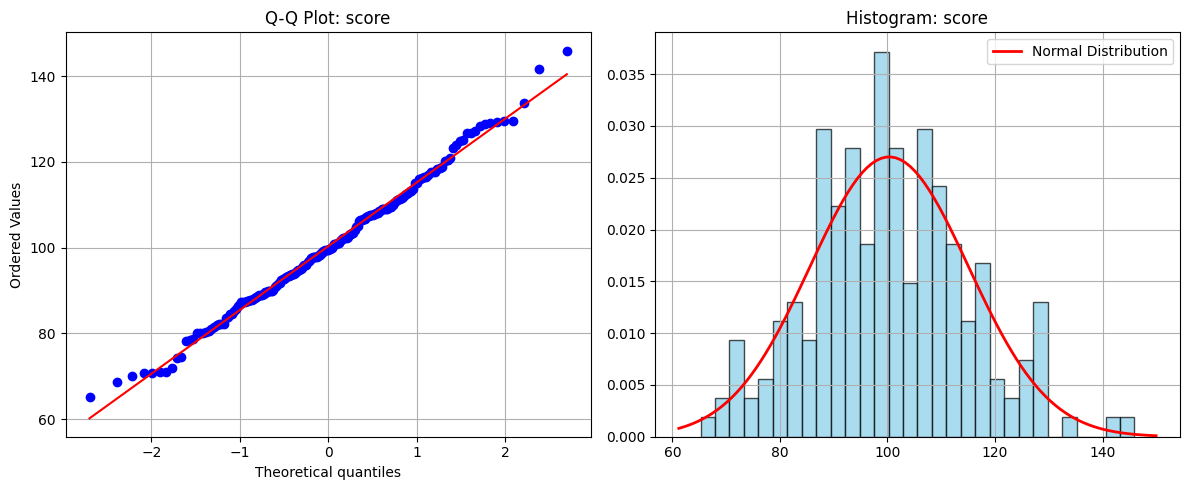

Shapiro-Wilk Test:
Statistic: 0.993434, P-value: 0.519023

=== ANOVA: score ~ group ===
ANOVA Table:
                sum_sq     df         F    PR(>F)
C(group)   1000.798696    2.0  2.325059  0.100455
Residual  42398.359922  197.0       NaN       NaN

=== LINEAR MIXED MODEL: score ===
Mixed Effects Model Summary:
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: score    
No. Observations: 200     Method:             REML     
No. Groups:       200     Scale:              107.6101 
Min. group size:  1       Log-Likelihood:     -814.9350
Max. group size:  1       Converged:          Yes      
Mean group size:  1.0                                  
-------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025  0.975]
-------------------------------------------------------
Intercept  101.953    1.806 56.459 0.000 98.413 105.492
group[T.B]   0.143    2.606  0.055 0.956 -4.964   5.250
group[T.C]  -4.576    

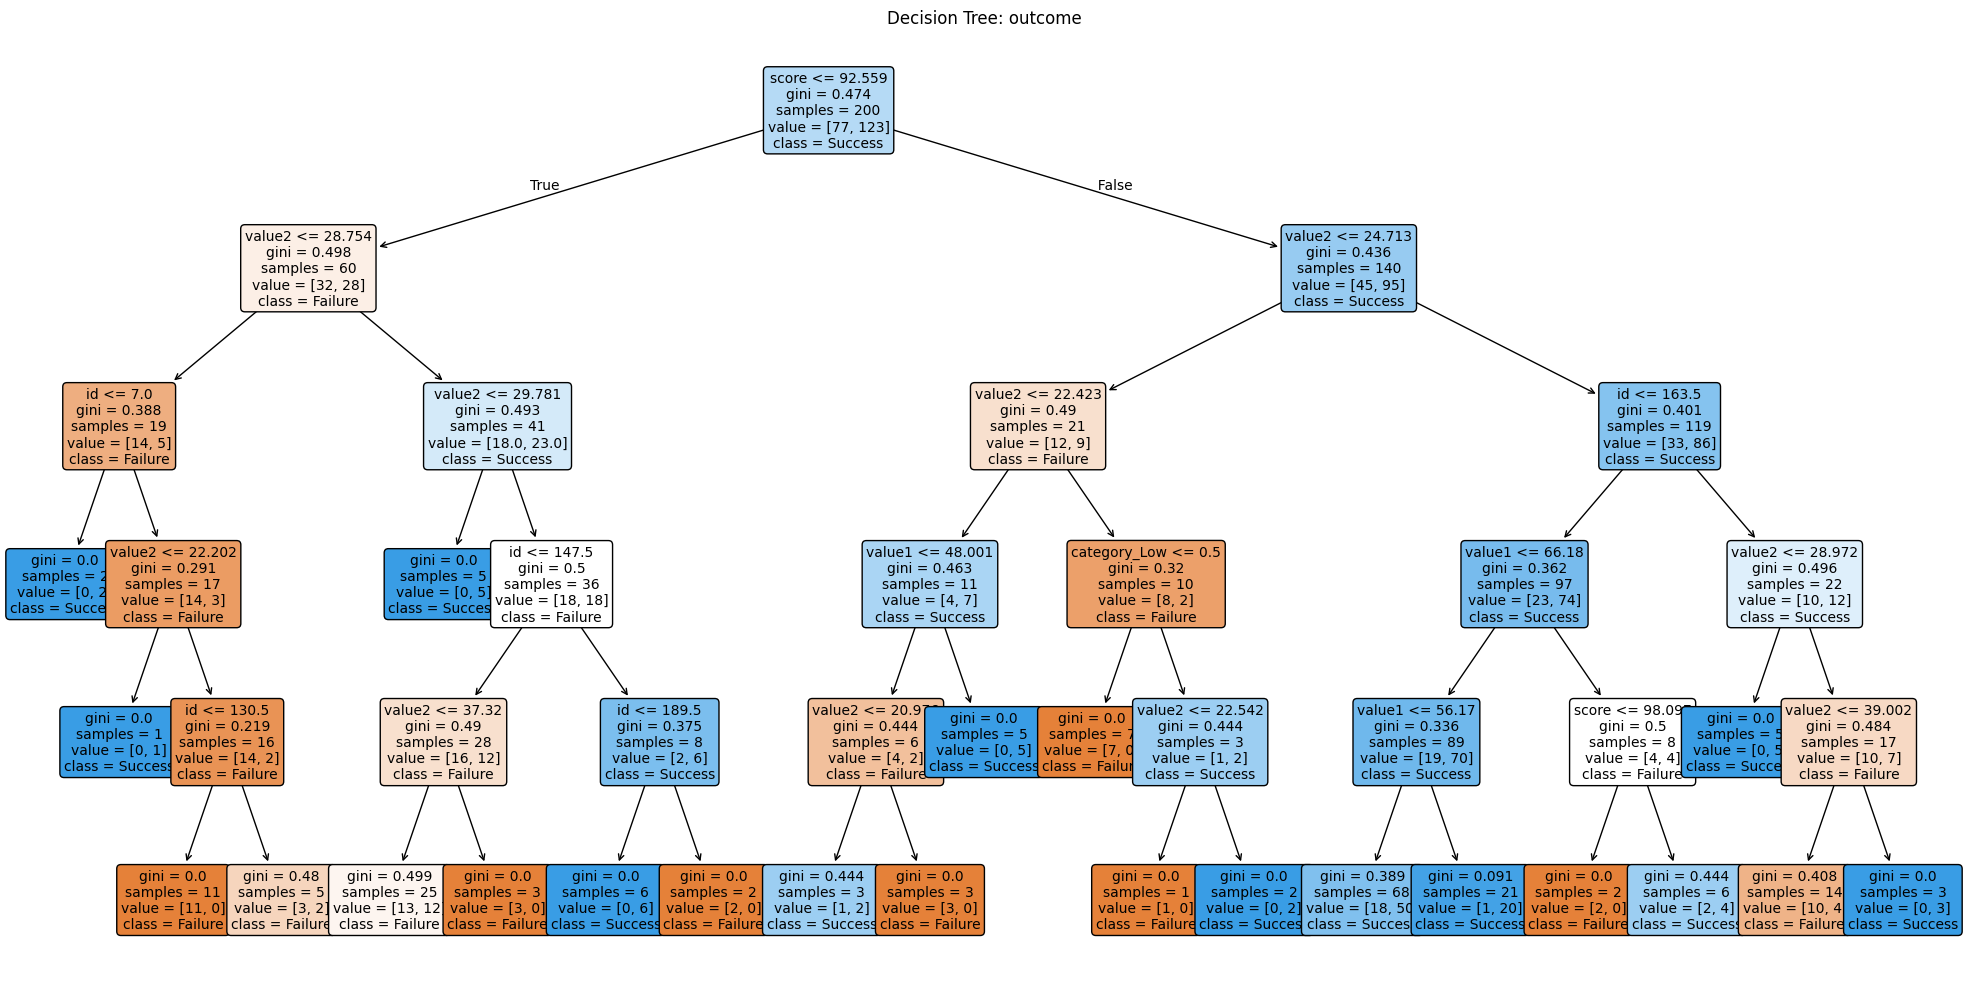

Feature Importance:
        feature  importance
3        value2    0.481985
0            id    0.227803
2        value1    0.123182
1         score    0.122309
6  category_Low    0.044721

=== HEATMAP ANALYSIS ===


<Figure size 1200x1000 with 0 Axes>

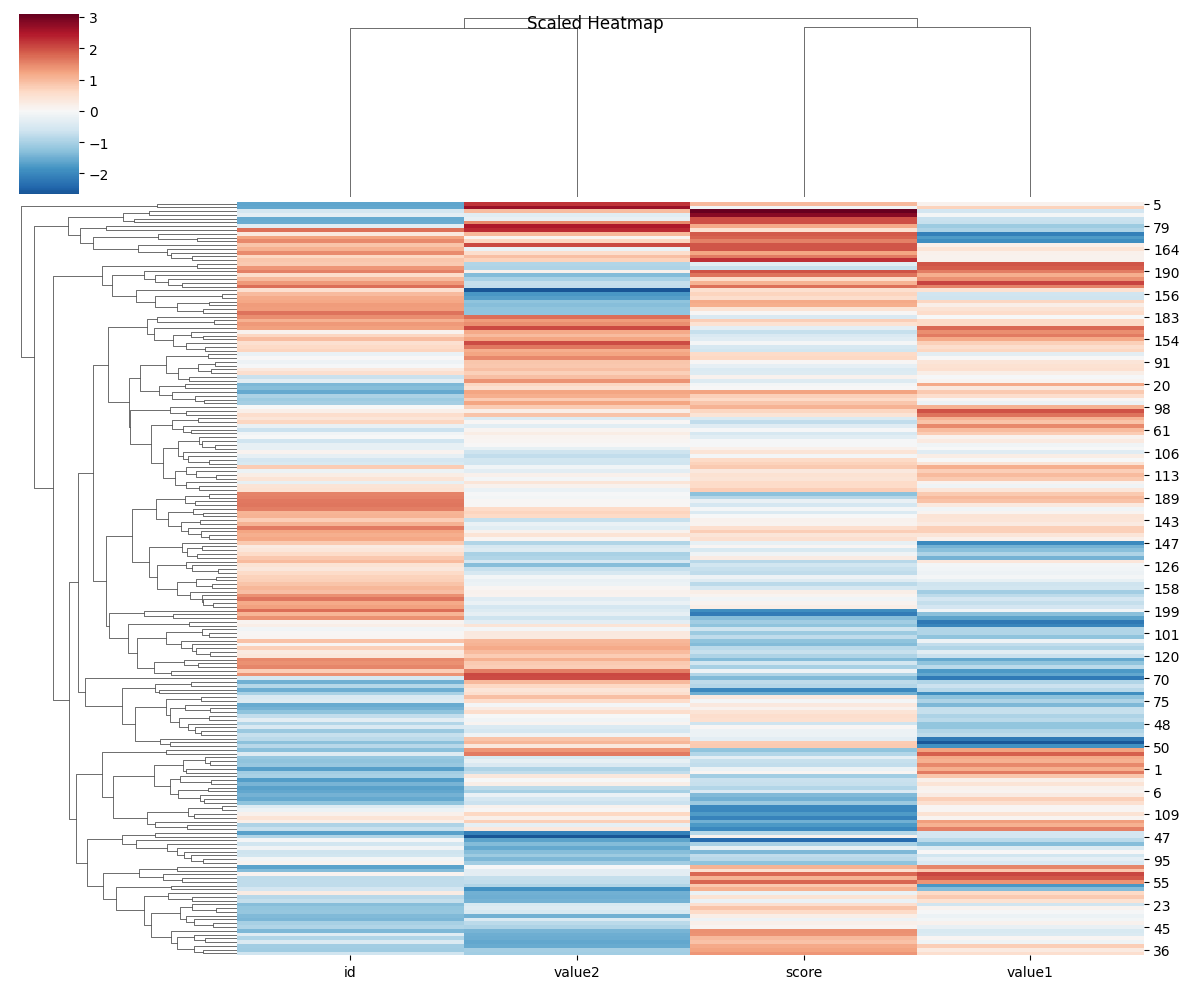


####################################################
# PYTHON ANALYSIS COMPLETE - ALL FUNCTIONS EXECUTED #
####################################################

=== ANALYSIS RESULTS SUMMARY ===
✅ descriptive: Complete
✅ correlations: Complete
✅ group_comparison: Complete
✅ assumptions: Complete
✅ anova: Complete
✅ mixed_model: Complete
✅ decision_tree: Complete
✅ heatmap: Complete


In [20]:
def create_sample_data() -> pd.DataFrame:
    """
    Python equivalent of R's create_sample_data()
    """
    np.random.seed(42)
    n = 200
    
    data = pd.DataFrame({
        'id': np.arange(1, n + 1),
        'group': np.random.choice(['A', 'B', 'C'], size=n),
        'score': np.random.normal(100, 15, size=n),
        'category': np.random.choice(['Low', 'Medium', 'High'], size=n),
        'value1': np.random.normal(50, 10, size=n),
        'value2': np.random.normal(30, 5, size=n),
        'outcome': np.random.choice(['Success', 'Failure'], size=n, p=[0.6, 0.4])
    })
    
    return data

# Usage Example
if __name__ == "__main__":
    # Create sample data
    sample_data = create_sample_data()
    
    # Run complete analysis
    results = run_complete_analysis(
        data=sample_data,
        target_var='outcome',
        numeric_var='score', 
        group_var='group',
        id_var='id'
    )
    
    # Access individual results
    print("\n=== ANALYSIS RESULTS SUMMARY ===")
    for key, value in results.items():
        if value is not None:
            print(f"✅ {key}: Complete")
        else:
            print(f"⏭️ {key}: Skipped")
